# Creating a dataset using nff's code

In [1]:
import sys
import numpy as np
from importlib import reload
import networkx as nx

import torch
from torch.utils.data import DataLoader

import sys
sys.path.append("../..")

In [2]:
import nff.data as d

### Data: ethanol trajectories

For this example, we are using an ethanol dataset provided by Wujie. It is a simple and good benchmark on how we can create a dataset from raw data. Below, we start by loading the raw data:

In [3]:
ethanol_data = np.load('ethanol_ccsd_t-train.npz')
nxyz_data = np.dstack((np.array([ethanol_data.f.z]*1000).reshape(1000, -1, 1), np.array(ethanol_data.f.R)))
force_data = ethanol_data.f.F
energy_data = ethanol_data.f.E.squeeze() - ethanol_data.f.E.mean()
smiles_data = ["COC"] * 1000

The Dataset requires a dictionary of lists for its properties. It also works with `energy_grad` instead of forces. To convert between the two, we have to invert the sign of the forces:

In [4]:
props = {
    'nxyz': nxyz_data.tolist(),
    'energy': energy_data.tolist(),
    'energy_grad': [(-x).tolist() for x in force_data],
    'smiles': smiles_data
}

### Creating the dataset

When creating the dataset, we have to supply it with the properties of interest and the units of the energy. The forces should be in the same system of units. XYZ positions should be in Å.

In [5]:
dataset = d.Dataset(props.copy(), units='kcal/mol')

Calculating the length of the dataset:

In [6]:
len(dataset)

1000

### Generating neighbor list

Managing the neighbor list of the input graphs is the responsibility of the data. The dataset has an in-built function to do so. It requires only the cutoff (in Å) to define atoms as neighbors:

In [7]:
dataset.generate_neighbor_list(cutoff=5)

We can plot an example of a graph by using the neighbor list we just computed:

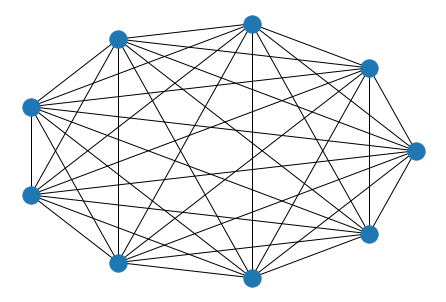

In [8]:
%matplotlib inline
nbr_list = dataset[0]['nbr_list'].numpy()
G = nx.from_edgelist(nbr_list)
nx.draw_kamada_kawai(G)

### Loading/saving dataset from file

We can save this dataset to a file by using its in-build method:

In [9]:
dataset.save('dataset.pth.tar')

Alternatively, we could load this same dataset directly:

In [10]:
dataset = d.Dataset.from_file('dataset.pth.tar')

## DataLoader

To create a dataloader for the dataset we just created, we use PyTorch's DataLoader and our custom collate function:

In [11]:
loader = DataLoader(dataset, batch_size=5, collate_fn=d.collate_dicts)

Example of a batch from this dataloader:

In [12]:
next(iter(loader))

{'energy': tensor([-4.3701,  2.3960, -2.9999,  7.7925, -3.2847]),
 'energy_grad': tensor([[ 10.2030, -33.6563,   1.9132],
         [-59.5878,  42.4086,  10.0746],
         [-36.9785,   2.0060,  18.7998],
         [ -1.8185,   5.6604,   4.6715],
         [ -1.8685,   0.9660,  -1.9927],
         [ 11.0286, -11.6878,  18.4956],
         [ 38.0142, -24.5804, -16.6240],
         [  5.8505,  15.7041, -12.9981],
         [ 35.1569,   3.1794, -22.3399],
         [ -3.2706,   6.2353,  -2.2947],
         [-37.2839, -57.8096,  21.6207],
         [ 22.4534,   8.3595,  34.7103],
         [ 38.1262,  -7.1657, -10.2844],
         [-18.7784, -22.9365,  -6.8353],
         [ 36.6467,  38.8382, -18.6973],
         [-15.1864,  22.2111,  -4.6346],
         [-13.6507,  19.7249, -10.8962],
         [ -9.0561,  -7.4571,  -2.6885],
         [ 18.7645, -14.1364,  26.2788],
         [-26.0875,  75.1377,   6.2471],
         [-15.4500, -26.2092,   5.8428],
         [  0.8040,  25.3065, -43.5145],
         [ -7.904